In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from pathlib import Path
from tqdm.auto import tqdm
from types import SimpleNamespace
import os
from PIL import Image
import csv

In [4]:
from pathlib import Path
import pandas as pd

class KITTIData:
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.label_path = self.base_dir / 'data_object_label_2' / 'training' / 'label_2'
        self.img_path = self.base_dir / 'data_object_image_2' / 'training' / 'image_2'
        self.img_stereo_path = self.base_dir / 'data_object_image_3' / 'training' / 'image_3'
        self.calib_path = self.base_dir / 'data_object_calib' / 'training' / 'calib'
        self.ims = sorted(list(self.img_path.glob('*')))
        self.labels = sorted(list(self.label_path.glob('*')))
        self.stereo_ims = sorted(list(self.img_stereo_path.glob('*')))
        self.label_colors = {
            'Car': (255, 0, 0),
            'Van': (255, 255, 0),
            'Truck': (255, 255, 255),
            'Pedestrian': (0, 255, 255),
            'Person_sitting': (0, 255, 255),
            'Cyclist': (0, 128, 255),
            'Tram': (128, 0, 0),
            'Misc': (0, 255, 255),
            'DontCare': (255, 255, 0)
        }
        self.label_cols = [
            'label', 'truncated', 'occluded', 'alpha',
            'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
            'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
            'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
        ]
        self.df = pd.DataFrame({
            'image': self.ims,
            'stereo_image': self.stereo_ims,
            'label': self.labels
        })
        self.im_width = 256
        self.im_height = 160

# Instantiate the class
kitti_data = KITTIData('/kaggle/input/kitti-dataset')


In [5]:
Data = kitti_data.df

In [6]:
def get_label(p):
    data =  pd.read_csv(
        p, 
        sep=" ",
        names=kitti_data.label_cols[:15],
        usecols = kitti_data.label_cols[:15]
    )
    return data

In [7]:
get_label(Data['label'][789])

,label,truncated,occluded,alpha,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,dim_height,dim_width,dim_length,loc_x,loc_y,loc_z,rotation_y
0,Pedestrian,0.0,0,0.24,361.13,146.41,434.46,314.22,1.89,0.48,1.2,-2.39,1.51,8.28,-0.03


In [8]:

def open_image(path):
    """
    Opens an image from the specified path and converts it to RGB format.
    
    Args:
    - path: The path to the image file.
    
    Returns:
    - image: The opened image in RGB format.
    """
    image = cv.imread(str(path))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

def draw_bb_box2d(idx, ax = None):
    """
    Draws bounding boxes on an image based on the labels in the dataset.

    Args:
    - idx: Index of the sample in the dataset.
    - ax: Optional parameter, matplotlib axis to plot the image.

    Returns:
    - None
    """
    sample = Data.iloc[idx, :]
    img = open_image(sample['image'])
    labels = get_label(sample['label'])
    for index, row in labels.iterrows():
        left_corner = (int(row.bbox_xmin), int(row.bbox_ymin))
        right_corner = (int(row.bbox_xmax), int(row.bbox_ymax))
        
        if row.label == 'DontCare':
            continue
        
        label_color = kitti_data.label_colors.get(row.label, (0, 255, 0))
        img = cv.rectangle(img, left_corner, right_corner, label_color, 2)
        img = cv.putText(img, row.label, 
                         (left_corner[0] + 10, left_corner[1] - 4), 
                         cv.FONT_HERSHEY_SIMPLEX, 1, 
                         label_color, 3)
    
    if ax == None:
        plt.imshow(img)
    else:
        ax.imshow(img)


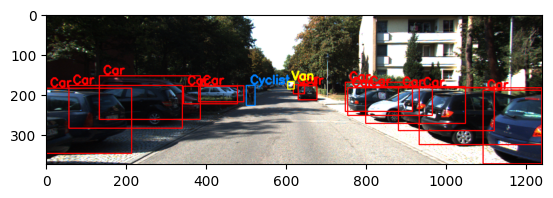

In [9]:
draw_bb_box2d(7480)

In [10]:
class Args:
    def __init__(self, label_dir, image_2_dir, training_samples, use_dont_care):
        """
        Initializes an Args object with specified arguments.

        Args:
        - label_dir: Directory containing label files.
        - image_2_dir: Directory containing image files.
        - training_samples: Number of training samples.
        - use_dont_care: Flag indicating whether to use 'DontCare' labels.
        """
        self.label_dir = label_dir  # Directory containing label files
        self.image_2_dir = image_2_dir  # Directory containing image files
        self.training_samples = training_samples  # Number of training samples
        self.use_dont_care = use_dont_care  # Flag indicating whether to use 'DontCare' labels



In [11]:
all_classes = []
OUT_LABELS_DIR = "labels_with_dont_care"
KEY_DONT_CARE = "DontCare"
class_names = ['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'Person_sitting', 'DontCare']
CLAZZ_NUMBERS = {name: idx for idx, name in enumerate(class_names)}

# Function to extract sample ID from file path
def get_sample_id(path):
    basename = os.path.basename(path)
    return os.path.splitext(basename)[0]

# Function to resolve class number or return None
def resolve_class_number_or_none(clazz, use_dont_care):
    if use_dont_care and clazz == KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    elif clazz != KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    return None

# Function to convert bounding box coordinates to YOLO format
def convert_to_yolo_bbox(bbox, size):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (bbox[0] + bbox[1]) / 2.0
    y = (bbox[2] + bbox[3]) / 2.0
    w = bbox[1] - bbox[0]
    h = bbox[3] - bbox[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

# Function to read real image size
def read_real_image_size(img_path):
    return Image.open(img_path).size

# Function to read fixed image size (if needed)
def read_fixed_image_size():
    return (1242, 375)

# Function to parse sample from KITTI annotations
def parse_sample(lbl_path, img_path, use_dont_care):
    with open(lbl_path) as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=["type", "truncated", "occluded", "alpha", "bbox2_left", "bbox2_top", "bbox2_right", "bbox2_bottom", "bbox3_height", "bbox3_width", "bbox3_length", "bbox3_x", "bbox3_y", "bbox3_z", "bbox3_yaw", "score"], delimiter=" ")
        yolo_labels = []
        for row in reader:
            all_classes.append(row['type'])
            clazz_number = resolve_class_number_or_none(row["type"], use_dont_care)
            if clazz_number is not None:
                size = read_real_image_size(img_path)
                bbox = (float(row["bbox2_left"]), float(row["bbox2_right"]), float(row["bbox2_top"]), float(row["bbox2_bottom"]))
                yolo_bbox = convert_to_yolo_bbox(bbox, size)
                yolo_label = (clazz_number,) + yolo_bbox
                yolo_labels.append(yolo_label)
    return yolo_labels

# Define arguments for processing
args = Args(
    label_dir=str(kitti_data.label_path),
    image_2_dir=str(kitti_data.img_path),
    training_samples=1,
    use_dont_care=True
)

# Create output directory if it does not exist
if not os.path.exists(OUT_LABELS_DIR):
    os.makedirs(OUT_LABELS_DIR)

# Generate darknet labels
print("Generating darknet labels...")
sample_img_paths = []
for dir_path, sub_dirs, files in os.walk(args.label_dir):
    for file_name in tqdm(files):
        if file_name.endswith(".txt"):
            lbl_path = os.path.join(dir_path, file_name)
            sample_id = get_sample_id(lbl_path)
            img_path = os.path.join(args.image_2_dir, "{}.png".format(sample_id))
            sample_img_paths.append(img_path)
            yolo_labels = parse_sample(lbl_path, img_path, args.use_dont_care)
            with open(os.path.join(OUT_LABELS_DIR, "{}.txt".format(sample_id)), "w") as yolo_label_file:
                for lbl in yolo_labels:
                    yolo_label_file.write("{} {} {} {} {}\n".format(*lbl))

Generating darknet labels...


  0%|          | 0/7481 [00:00<?, ?it/s]

In [17]:
import zipfile
import os

# Define the path to the directory you want to zip
directory_to_zip = '/kaggle/working/labels_with_dont_care'

# Create a zip file containing the directory
zip_file = '/kaggle/working/labels_with_dont_care.zip'
with zipfile.ZipFile(zip_file, 'w') as zipf:
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=os.path.relpath(os.path.join(root, file), directory_to_zip))

print(f"Directory '{directory_to_zip}' converted to '{zip_file}'")


Directory '/kaggle/working/labels_with_dont_care' converted to '/kaggle/working/labels_with_dont_care.zip'


In [12]:
import json

# Open a file named 'classes_with_dont_care.json' in write mode ('w')
with open('classes_with_dont_care.json', 'w') as f:
    # Use the json.dump() function to serialize the dictionary CLAZZ_NUMBERS
    # and write it to the file
    json.dump(CLAZZ_NUMBERS, f)


In [19]:
CLAZZ_NUMBERS

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}